In [1]:
# Importing Libraries:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import findspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import *
import findspark
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import *

findspark.init()

In [2]:
# Reading the data
data = pd.read_csv('cleaned.csv', encoding= 'unicode_escape') 
data=data.drop(['Unnamed: 0'], axis=1)
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,duration_of_stay
0,Renaissance Hotel,0,13,2018,July,27,1,0,1,1,...,A,0,No Deposit,304.0,0,Transient,75.00,0,0,1
1,Renaissance Hotel,0,14,2018,July,27,1,0,2,2,...,A,0,No Deposit,240.0,0,Transient,98.00,0,1,2
2,Renaissance Hotel,0,9,2018,July,27,1,0,2,2,...,C,0,No Deposit,303.0,0,Transient,103.00,0,1,2
3,Renaissance Hotel,1,85,2018,July,27,1,0,3,2,...,A,0,No Deposit,240.0,0,Transient,82.00,0,1,3
4,Renaissance Hotel,1,75,2018,July,27,1,0,3,2,...,D,0,No Deposit,15.0,0,Transient,105.50,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74844,JW Marriott Hotel,0,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,394.0,0,Transient,96.14,0,0,7
74845,JW Marriott Hotel,0,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,9.0,0,Transient,225.43,0,2,7
74846,JW Marriott Hotel,0,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,9.0,0,Transient,157.71,0,4,7
74847,JW Marriott Hotel,0,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,89.0,0,Transient,104.40,0,0,7


In [3]:
# Number of rows and columns in the data set
rows,cols=data.shape

In [4]:
# Names of all the column
for col in data.columns:
    print(col)

hotel
is_canceled
lead_time
arrival_date_year
arrival_date_month
arrival_date_week_number
arrival_date_day_of_month
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
meal
country
distribution_channel
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
reserved_room_type
assigned_room_type
booking_changes
deposit_type
agent
days_in_waiting_list
customer_type
adr
required_car_parking_spaces
total_of_special_requests
duration_of_stay


In [5]:
#Total number of duplicated rows--> no duplicated row 
data.duplicated().sum()

3

In [6]:
# Dropping duplicated rows
data=data.drop_duplicates()

In [7]:
# Checking if there are missing data
data.isnull().values.any()

False

In [8]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

23/06/08 21:28:37 WARN Utils: Your hostname, Lojins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.12 instead (on interface en0)
23/06/08 21:28:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 21:28:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
# Loading the data into spark dataframe
df1 = spark.createDataFrame(data) 
# Checking that columns were inserted correctly 
df1.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_date_year: long (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: long (nullable = true)
 |-- arrival_date_day_of_month: long (nullable = true)
 |-- stays_in_weekend_nights: long (nullable = true)
 |-- stays_in_week_nights: long (nullable = true)
 |-- adults: long (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: long (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: long (nullable = true)
 |-- previous_cancellations: long (nullable = true)
 |-- previous_bookings_not_canceled: long (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: long (nullable = true)
 |-- deposit_type: string 

Insight One

In [10]:
# Season with most guests
durationOfStay = df1.groupby("arrival_date_month", "duration_of_stay")\
.agg(count("*").alias("count"))\
.withColumn("total",  (F.col("count"))* F.col("duration_of_stay") )
durationOfStay.show()
season = durationOfStay.groupby("total", "arrival_date_month").count()
season.groupBy("arrival_date_month").sum("total").show()

23/06/08 21:28:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+----------------+-----+-----+
|arrival_date_month|duration_of_stay|count|total|
+------------------+----------------+-----+-----+
|          November|              12|   10|  120|
|             April|               0|   22|    0|
|              June|              21|    4|   84|
|              July|              13|   16|  208|
|           October|              17|    1|   17|
|          November|               7|  267| 1869|
|          November|               4|  739| 2956|
|          December|              19|    6|  114|
|          December|              10|   37|  370|
|           January|              14|   32|  448|
|          November|               0|   58|    0|
|               May|              10|   86|  860|
|          December|              18|    4|   72|
|           October|              22|    4|   88|
|              June|               3| 1580| 4740|
|         September|               1|  913|  913|
|           October|              10|   33|  330|


In [11]:
# Define the mapping of months to seasons

#Autumn - September, October, November.
#Winter - December, January and February.
#Spring - March, April and May. 
#Summer - June, July and August
from pyspark.sql.functions import when, col, sum

season_mapping = {
    "Autumn": ["September", "October", "November"],
    "Winter": ["December", "January", "February"],
    "Spring": ["March", "April", "May"],
    "Summer": ["June", "July", "August"]
}

# Apply the mapping and calculate the sum for each season
df_transformed = season.withColumn("season",
                               when(col("arrival_date_month").isin(season_mapping["Autumn"]), "Autumn")
                               .when(col("arrival_date_month").isin(season_mapping["Winter"]), "Winter")
                               .when(col("arrival_date_month").isin(season_mapping["Spring"]), "Spring")
                               .when(col("arrival_date_month").isin(season_mapping["Summer"]), "Summer")
                               .otherwise("Unknown")
                               ) \
                   .groupBy("season") \
                   .sum("total")

# Show the transformed DataFrame
df_transformed.show()

+------+----------+
|season|sum(total)|
+------+----------+
|Spring|     73157|
|Summer|    110937|
|Autumn|     57060|
|Winter|     44741|
+------+----------+



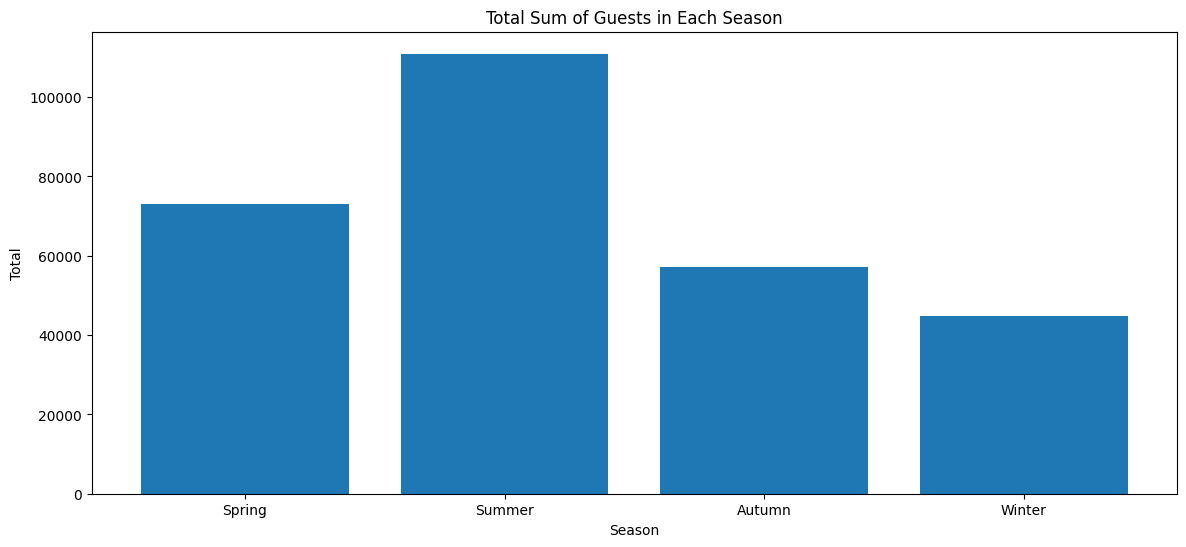

From the plot above, we can say that Summer is the most season of attraction


In [12]:
# Collect the data from the DataFrame
season = [row['season'] for row in df_transformed.select(col('season')).collect()]
totals = [row['sum(total)'] for row in df_transformed.select(col('sum(total)')).collect()]

# Plotting the data
plt.figure(figsize=(14, 6))
plt.bar(season, totals)
plt.xlabel("Season")
plt.ylabel("Total")
plt.title("Total Sum of Guests in Each Season")
plt.show()

# Converting the results to a Pandas DataFrame for visualization
seasonDf = df_transformed.toPandas()
seasonDf
df2=seasonDf.loc[seasonDf['sum(total)'].idxmax()]
source= df2['season']
print('From the plot above, we can say that', source, 'is the most season of attraction')

Insight Two

In [13]:
#eh aktar sana hasal feeha cancellation and trhis will be aktar sana hasal feeha khosara lelhotel
Cancellation=df1.groupBy("hotel","is_canceled").count()
Cancellation.show()
Cancellation = Cancellation.withColumn("is_canceled", when(Cancellation.is_canceled == "0","Reserved") \
      .when(Cancellation.is_canceled == "1","Cancelled") \
      .otherwise(Cancellation.is_canceled))
Cancellation.show()

+-----------------+-----------+-----+
|            hotel|is_canceled|count|
+-----------------+-----------+-----+
|Renaissance Hotel|          1| 7180|
|Renaissance Hotel|          0|19990|
|JW Marriott Hotel|          1|15057|
|JW Marriott Hotel|          0|32619|
+-----------------+-----------+-----+

+-----------------+-----------+-----+
|            hotel|is_canceled|count|
+-----------------+-----------+-----+
|Renaissance Hotel|  Cancelled| 7180|
|Renaissance Hotel|   Reserved|19990|
|JW Marriott Hotel|  Cancelled|15057|
|JW Marriott Hotel|   Reserved|32619|
+-----------------+-----------+-----+



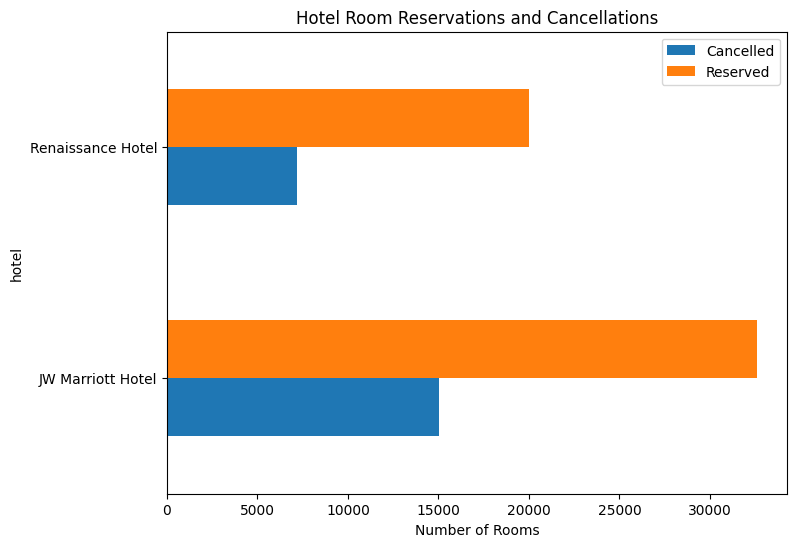

Based on the results of the query and the graph above the Renaissance Hotel is with the highest reservation rate 73.6 and lowest cancellation rate 26.4


In [14]:
# Visualising the data
# Converting the results to a Pandas DataFrame for visualization
Cancellation_DataFrame = Cancellation.toPandas()

# Filter the DataFrame to only include Reserved rows
reserved = Cancellation_DataFrame[Cancellation_DataFrame['is_canceled'] == 'Reserved']
# Filter the DataFrame to only include Cancelled rows
cancelled=Cancellation_DataFrame[Cancellation_DataFrame['is_canceled'] == 'Cancelled']

#Merging bothe dataframes:
outputDataframe = pd.pivot_table(
    pd.concat([reserved, cancelled]),
    values='count',
    index=['hotel'],
    columns=['is_canceled'],
    fill_value=0
)

# Calculating the rates 
outputDataframe['cancellation_rate'] = outputDataframe['Cancelled'] / ((outputDataframe['Cancelled'] + outputDataframe['Reserved'])) * 100
outputDataframe['reservation_rate'] = outputDataframe['Reserved'] / ((outputDataframe['Cancelled'] + outputDataframe['Reserved'])) * 100

# Getting the hotel with the highest reservation rate and lowest cancellation rate
best_hotel = outputDataframe.nsmallest(1, 'cancellation_rate').nlargest(1, 'Reserved').index[0]
best_hotel_row = outputDataframe.loc[[best_hotel], :]
cancellation_rate = best_hotel_row.loc[best_hotel, 'cancellation_rate']
reservation_rate = best_hotel_row.loc[best_hotel, 'reservation_rate']
c = "{:.3g}".format(cancellation_rate)
r = "{:.3g}".format(reservation_rate)

# Visualizing the results:

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
outputDataframe[['Cancelled', 'Reserved']].plot(kind='barh', ax=ax)

# set the x-axis label
ax.set_xlabel('Number of Rooms')

# set the title and legend
ax.set_title('Hotel Room Reservations and Cancellations')
ax.legend(['Cancelled', 'Reserved'], loc='upper right')

plt.show()
print("Based on the results of the query and the graph above the",best_hotel, "is with the highest reservation rate", r,"and lowest cancellation rate",c)


Insight Three

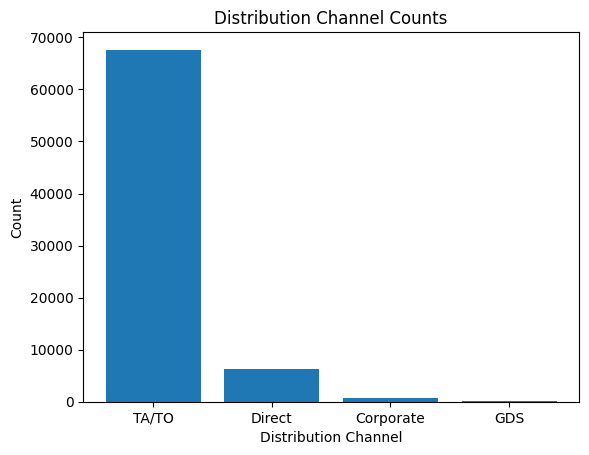

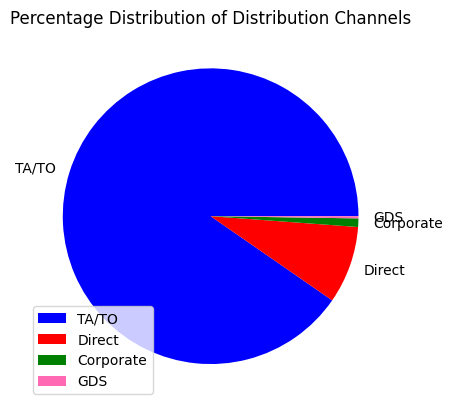

Based on the results we can say that bookings come from  TA/TO the most.
The hotel can consider investing more in this channel.
For Example:
1) Include building stronger relationships with these partners by :
A- offering them better commission rates, or providing them with additional marketing materials to promote the hotel.
B- providing them with additional marketing materials to promote the hotel.
Also the hotel can offer 10% from other guests coming from other channels to increase its guests


23/06/08 21:28:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [15]:
# Getting the count of each distribution channel to know which is more used:

# Getting the total number of all distribution channels:
query= df1.groupby(df1['distribution_channel'])\
.agg({"distribution_channel": "count"})\
.sort("distribution_channel", ascending=False)

total_distribution_channels = query.agg(sum("count(distribution_channel)")).collect()[0][0]

# Calculating the percentage of each one of them 
distributionChannel= df1.groupby(df1['distribution_channel'])\
.agg({"distribution_channel": "count"})\
.withColumn("percentage",( ((F.col("count(distribution_channel)"))/total_distribution_channels)*100) ) \
.sort("distribution_channel", ascending=False)
#distributionChannel.show()

# Converting the results to a Pandas DataFrame for visualization
distributionChannel_pd = distributionChannel.toPandas()
distributionChannel_pd = distributionChannel_pd.sort_values("percentage", ascending=False)

# Getting the distribution channel with the highest percentage:
source = distributionChannel_pd.iloc[0]["distribution_channel"]

# Creating a bar chart of the distribution channel counts
plt.bar(distributionChannel_pd["distribution_channel"], distributionChannel_pd["count(distribution_channel)"])
plt.title("Distribution Channel Counts")
plt.xlabel("Distribution Channel")
plt.ylabel("Count")
plt.show()

y = np.array(distributionChannel_pd["percentage"])
mycolors = ["b","r", "g",  "hotpink"]
plt.pie(y, labels=distributionChannel_pd['distribution_channel'], colors=mycolors)
plt.title("Percentage Distribution of Distribution Channels")
plt.legend(loc='lower left')
plt.show()

if(source == "TA/TO"):
    print("Based on the results we can say that bookings come from ",source, "the most.")
    print("The hotel can consider investing more in this channel.")
    print("For Example:")
    print("1) Include building stronger relationships with these partners by :")
    print("A- offering them better commission rates, or providing them with additional marketing materials to promote the hotel.")
    print("B- providing them with additional marketing materials to promote the hotel.")
if(source== "Direct"):
    print("Based on the results we can say that bookings come from ",source, "the most.")
    print("The hotel can consider investing more in these channels.")
    print("For Example:")
    print("1) Optimize the hotel's website")
    print("2) Offer incentives for direct bookings")
    print("3) Use targeted marketing campaigns")
if(source== "Corporate"):
    print("Based on the results we can say that bookings come from ",source, "the most.")
    print("The hotel can consider investing more in these channels.")
    print("For Example:")
    print("1) Build stronger relationships with corporate clients by :")
    print("A- offering special rates or packages for corporate clients")
    print("B- providing additional amenities or services")
    print("2) Expand corporate partnerships by:")
    print("A- partnering with local businesses, attending corporate events or conferences,")
    print("B- eaching out to corporate travel agencies")
if(source== "GDS"):
    print("Based on the results we can say that bookings come from ",source, "the most.")
    print("The hotel can consider investing more in these channels.")    
print('Also the hotel can offer 10% from other guests coming from other channels to increase its guests')    